# 1. Community detection
Generate a random network with 200 nodes and three communities. Two communities should be sub-
stantially larger than the third one. For example, the first community can have 90 nodes, the second 70,
and the third one 40 nodes. To generate a strong community structure with more links within the groups
and less links between the groups you can use stochastic block model generator, e.g., SBM.

In [60]:
from functools import partial
from queue import PriorityQueue

import numpy as np
import scipy as sp
import networkx as nx
from infomap import Infomap
from sklearn import metrics
from matplotlib import colormaps

In [2]:
n = 3
sizes = np.array([90, 70, 40])
probs = np.array([[0.817, 0.049, 0.041], [0.049, 0.784, 0.05], [0.041, 0.05, 0.808]])
probs


array([[0.817, 0.049, 0.041],
       [0.049, 0.784, 0.05 ],
       [0.041, 0.05 , 0.808]])

In [3]:
g = nx.stochastic_block_model(sizes, probs)

In [4]:
true_clusters = list(nx.get_node_attributes(g, 'block').values())

In [5]:
nx.set_node_attributes(g, [None] * 200, 'block')

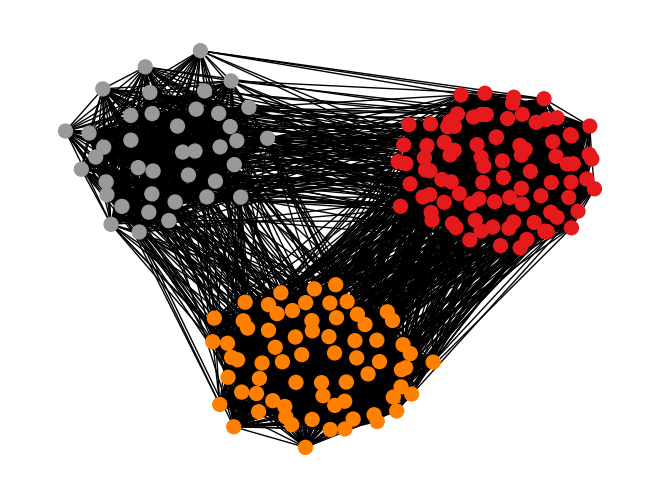

In [6]:
nx.draw(g, node_color=true_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

We will use a purity score for the evaluation of the clustering quality. The value is in range $[0, 1]$.

In [7]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

Using your generated network as the ground truth evaluate the following algorithms for community detection.

## Kernighan-Lin
We will use priority queue for searching for min cut size and will precompute cut size and subgraphs.

In [8]:
def kern_lin_bisect(graph):
    clusters = nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(graph, max_iter=100, seed=42)
    T, S = list(clusters[0]), list(clusters[1])
    cut_value = nx.cut_size(graph, T, S)
    return cut_value, (T, S)

This function will be universal for binary cut so we will reuse it, that is why we add bisect method as one more function argument.

In [10]:
def bisect_clustering(graph, n, bisect_method):
    subgraphs = PriorityQueue()
    subgraphs.put(bisect_method(graph))
    while n > 1:
        _, (T, S) = subgraphs.get()
        subgraphs.put(bisect_method(graph.subgraph(T)))
        subgraphs.put(bisect_method(graph.subgraph(S)))
        n -= 1
    result = []
    while subgraphs.qsize() > 0:
        _, (T, S) = subgraphs.get()
        result.append(T + S)
    return result
        

In [12]:
kern_lin_clusters = bisect_clustering(g, 3, kern_lin_bisect)

In [13]:
def sort_clusters_in_nodes_order(clusters):
    node_comm_pairs = {
        node: idx
        for idx, cluster in enumerate(clusters)
        for node in cluster
    }
    result = dict(sorted(node_comm_pairs.items(), key=lambda x: x[0]))
    return list(result.values())

In [14]:
predicted_clusters = sort_clusters_in_nodes_order(kern_lin_clusters)

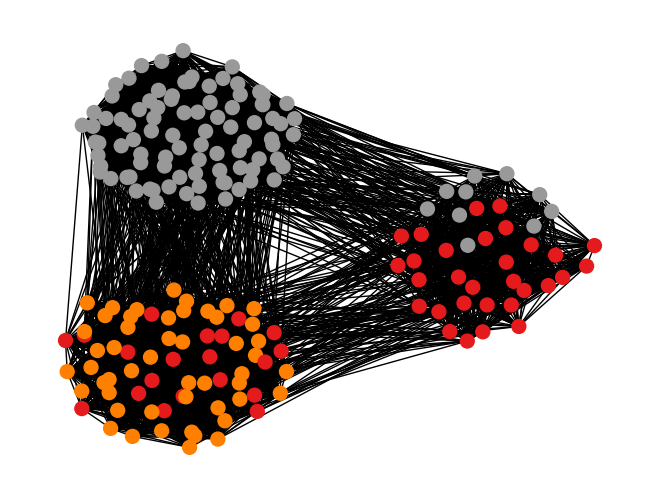

In [15]:
nx.draw(g, node_color=predicted_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [16]:
purity_score(true_clusters, predicted_clusters)

0.85

The problem of this method is bisecting into same size communities while ground truth clusters have different sizes. Also the problem is that we need to apply this method recursively so need to prioritize which subgraph to take first.

## Greed modularity maximization
We will use the Clauset-Newman-Moore greedy modularity maximization.

In [17]:
greedy_clusters = nx.algorithms.community.greedy_modularity_communities(g)

In [18]:
predicted_greedy_clusters = sort_clusters_in_nodes_order(greedy_clusters)

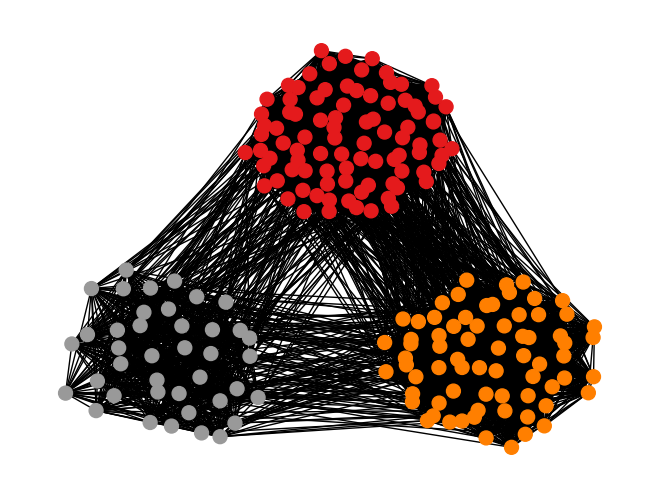

In [20]:
nx.draw(g, node_color=predicted_greedy_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [21]:
purity_score(true_clusters, predicted_greedy_clusters)

1.0

So, the Greedy modularity maximization method gives the exact result as True clusters are.

## Method on my choice
I hae chosen the InfoMap method for community detection.

In [22]:
im = Infomap("--two-level --silent")
mapping = im.add_networkx_graph(g)

In [ ]:
im.run()

In [24]:
infomap_result = {
    node.physicalId: node.moduleIndex()
    for node in im.nodes
}
result = dict(sorted(infomap_result.items(), key=lambda x: x[0]))
infomap_pred_clusters = list(result.values())

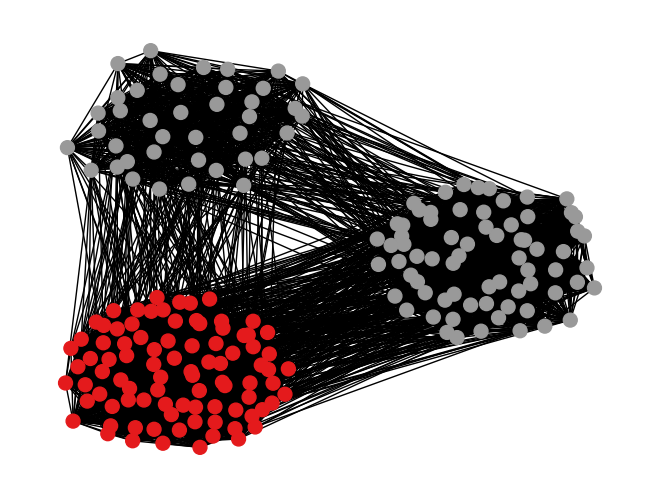

In [25]:
nx.draw(g, node_color=infomap_pred_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [26]:
purity_score(true_clusters, infomap_pred_clusters)

0.8

As we can see InfoMap algorithm can fully restore the community structure.

## Spectral methods
### Graph Laplacian

We will use `nx.spectral_bisection` method as a method for besection for the graph.

In [11]:
def fiedler_vector_bisect(graph):
    (S, T) = nx.spectral_bisection(graph)
    S = list(S)
    T = list(T)
    cut_size = nx.cut_size(graph, T, S)
    return cut_size, (T, S)

In [12]:
fiedler_clusters = bisect_clustering(g, 3, fiedler_vector_bisect)

In [14]:
fiedler_prediction = sort_clusters_in_nodes_order(fiedler_clusters)

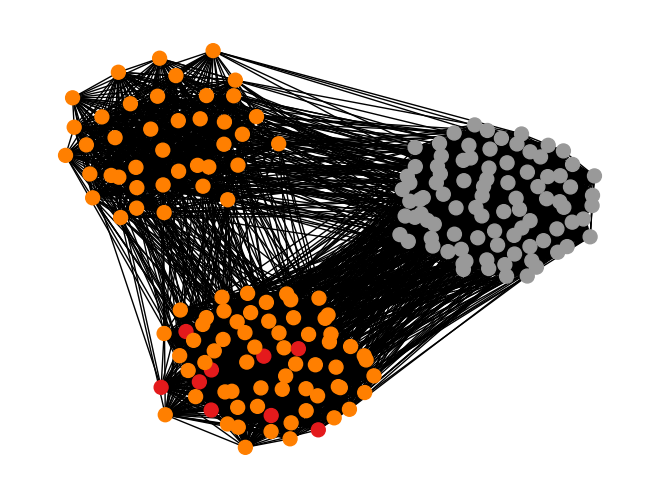

In [15]:
nx.draw(g, node_color=fiedler_prediction, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [16]:
purity_score(true_clusters, fiedler_prediction)

0.8

So, this method is a little bit worser than Kernighan-Lin.

### Modularity matrix
We will use custom written methods and try different eigenvalues count.

In [25]:
def leading_modularity_eigenvector(network, eigenvalues_taken):
    M = nx.modularity_matrix(network).astype(float)
    w, v = sp.sparse.linalg.eigs(M, which="LM", k=eigenvalues_taken, return_eigenvectors=True)
    return v[:, np.argsort(np.absolute(w))][:, -1]

In [26]:
def spectral_modularity_bisect(graph, taken_eigenvalues):
    leading = leading_modularity_eigenvector(graph, taken_eigenvalues)
    all_nodes = np.array(graph.nodes)
    S = list(all_nodes[leading > 0])
    T = list(all_nodes[leading <= 0])
    cut_size = nx.cut_size(graph, T, S)
    return cut_size, (T, S)

In [27]:
def spectral_modularity_clustering(graph, n, eigenvalues):
    bisect_method = partial(spectral_modularity_bisect, taken_eigenvalues=eigenvalues)
    spectral_clusters = bisect_clustering(graph, n, bisect_method)
    spectral_prediction = sort_clusters_in_nodes_order(spectral_clusters)
    print(f"Purity score: {purity_score(true_clusters, spectral_prediction)}")
    nx.draw(g, node_color=spectral_prediction, node_size=100, cmap=colormaps.get_cmap('Set1'))

Purity score: 1.0


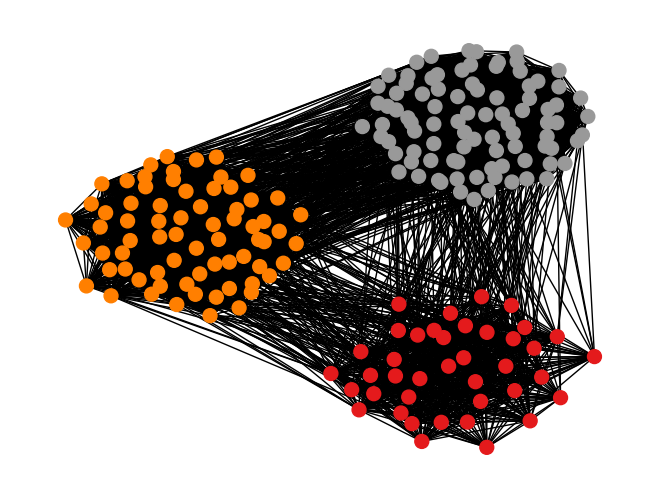

In [28]:
spectral_modularity_clustering(g, 3, 2)

Purity score: 1.0


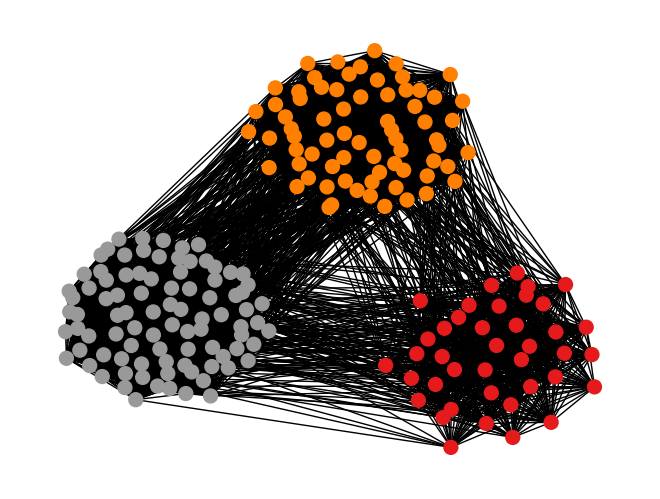

In [30]:
spectral_modularity_clustering(g, 3, 5)

Purity score: 1.0


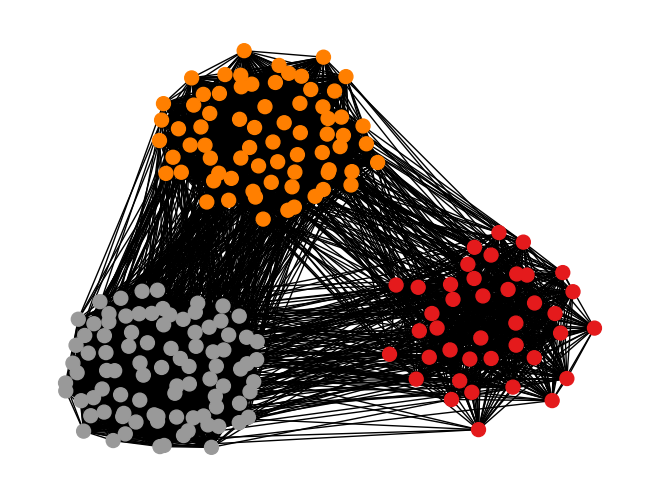

In [31]:
spectral_modularity_clustering(g, 3, 10)

So, you see the spectral modularity method gives exact clusters as the ground truth.

## Real network
We will use a Karate Club empirical network. We will use greedy modularity maximization and InfoMap methods because they do not need the number of exact clusters we need.

In [32]:
karate = nx.karate_club_graph()

In [38]:
karate.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [47]:
club = [
    int(karate.nodes[i]['club'] == "Mr. Hi")
    for i in karate.nodes
]

In [49]:
for i in karate.nodes:
    del karate.nodes[i]['club']

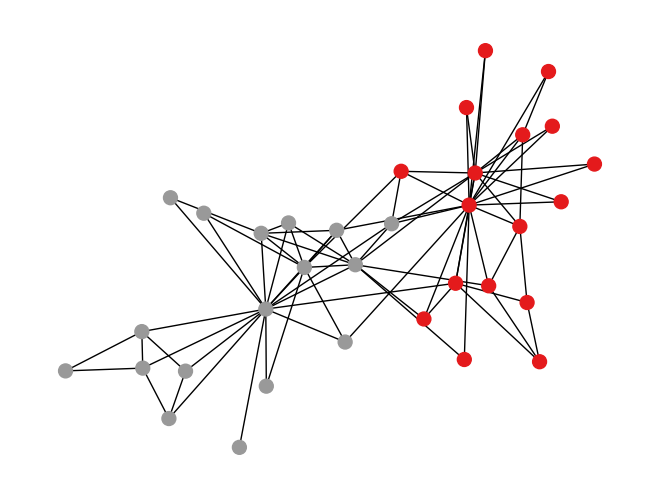

In [50]:
nx.draw(karate, node_color=club, node_size=100, cmap=colormaps.get_cmap('Set1'))

Now let's apply our methods.

In [51]:
karate_greedy_clusters = greedy_clusters = nx.algorithms.community.greedy_modularity_communities(karate)
karate_greedy_prediction = sort_clusters_in_nodes_order(karate_greedy_clusters)

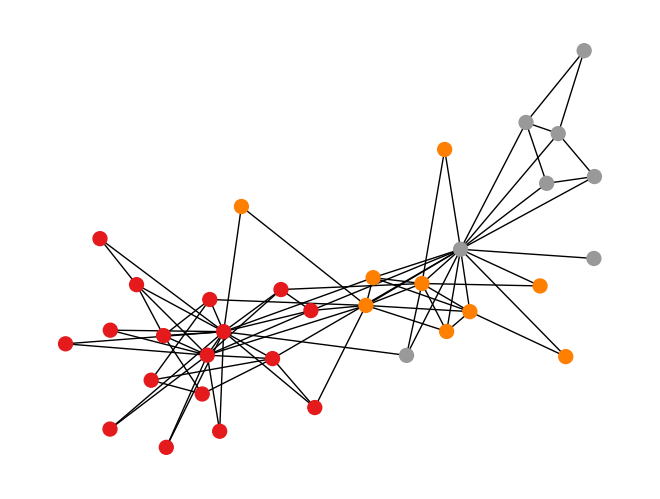

In [52]:
nx.draw(karate, node_color=karate_greedy_prediction, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [53]:
purity_score(club, karate_greedy_prediction)

0.9411764705882353

The greedy modularity method assigns 3 clusters instead of 2 ground truth.

In [55]:
im = Infomap("--two-level --silent")
mapping = im.add_networkx_graph(karate)

In [56]:
im.run()

In [57]:
infomap_result = {
    node.physicalId: node.moduleIndex()
    for node in im.nodes
}
result = dict(sorted(infomap_result.items(), key=lambda x: x[0]))
infomap_pred_clusters = list(result.values())

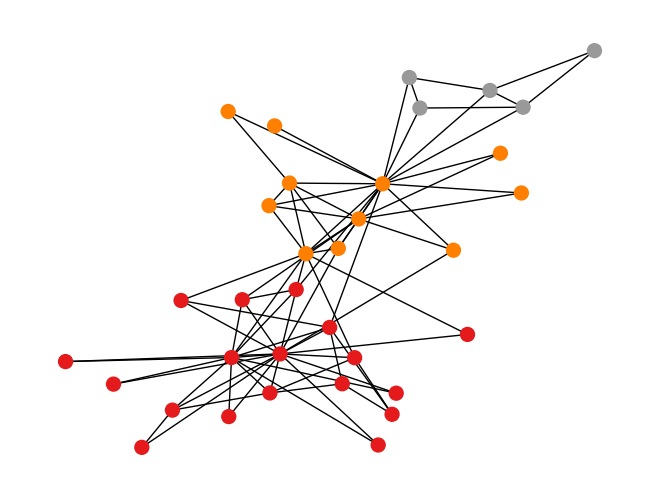

In [58]:
nx.draw(karate, node_color=infomap_pred_clusters, node_size=100, cmap=colormaps.get_cmap('Set1'))

In [59]:
purity_score(club, infomap_pred_clusters)

0.9705882352941176

The InfoMap algorithm also assigns 3 clusters instead of 2 but with better purity metric. Infact the InfoMap algorithm optimizes the information flow from cluster to cluster and the greedy optimization algorithm optimizes the number of links between different clusters, that is why these methods have different results.